In [1]:
import data
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
matrix = data.read_and_create_user_Matrix()
print(matrix.shape)

num_input = 16980
num_hidden_1=2048
num_hidden_2=1024
num_hidden_3=512
num_hidden_4=256
num_hidden_5=128

X = tf.placeholder(tf.float64, [None, num_input])

(5551, 16980)


In [3]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1], dtype=tf.float64)),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], dtype=tf.float64)),
    'encoder_h3': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3], dtype=tf.float64)),
    'encoder_h4': tf.Variable(tf.random_normal([num_hidden_3, num_hidden_4], dtype=tf.float64)),
    'encoder_h5': tf.Variable(tf.random_normal([num_hidden_4, num_hidden_5], dtype=tf.float64)),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_5, num_hidden_4], dtype=tf.float64)),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_4, num_hidden_3], dtype=tf.float64)),
    'decoder_h3': tf.Variable(tf.random_normal([num_hidden_3, num_hidden_2], dtype=tf.float64)),
    'decoder_h4': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1], dtype=tf.float64)),
    'decoder_h5': tf.Variable(tf.random_normal([num_hidden_1, num_input], dtype=tf.float64)),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3], dtype=tf.float64)),
    'encoder_b4': tf.Variable(tf.random_normal([num_hidden_4], dtype=tf.float64)),
    'encoder_b5': tf.Variable(tf.random_normal([num_hidden_5], dtype=tf.float64)),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_4], dtype=tf.float64)),
    'decoder_b2': tf.Variable(tf.random_normal([num_hidden_3], dtype=tf.float64)),
    'decoder_b3': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'decoder_b4': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'decoder_b5': tf.Variable(tf.random_normal([num_input], dtype=tf.float64)),
}

In [4]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    # Encoder Hidden layer with sigmoid activation #3
    layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    # Encoder Hidden layer with sigmoid activation #4
    layer_4 = tf.nn.tanh(tf.add(tf.matmul(layer_3, weights['encoder_h4']), biases['encoder_b4']))
    # Encoder Hidden layer with sigmoid activation #5
    layer_5 = tf.nn.tanh(tf.add(tf.matmul(layer_4, weights['encoder_h5']), biases['encoder_b5']))
    return layer_5


# Building the decoder

def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation #3
    layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['decoder_h3']), biases['decoder_b3']))
    # Decoder Hidden layer with sigmoid activation #4
    layer_4 = tf.nn.tanh(tf.add(tf.matmul(layer_3, weights['decoder_h4']), biases['decoder_b4']))
    # Decoder Hidden layer with sigmoid activation #5
    layer_5 = tf.nn.sigmoid(tf.add(tf.matmul(layer_4, weights['decoder_h5']), biases['decoder_b5']))
    return layer_5

In [5]:
# Construct model
with tf.device("/gpu:0"):
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)


    # Prediction

    y_pred = decoder_op


    # Targets are the input data.

    y_true = X


    # Define loss and optimizer, minimize the squared error


    # loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.losses.sigmoid_cross_entropy(y_true, y_pred)


    # optimizer = tf.train.RMSPropOptimizer(0.003).minimize(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.1).minimize(loss)
    # optimizer = tf.train.AdagradOptimizer(1e-4).minimize(loss)


    predictions = pd.DataFrame()

    # Define evaluation metrics

    eval_x = tf.placeholder(tf.int32, )
    eval_y = tf.placeholder(tf.int32, )
    pre, pre_op = tf.metrics.precision(labels=eval_x, predictions=eval_y)

    # Initialize the variables (i.e. assign their default value)

    init = tf.global_variables_initializer()
    local_init = tf.local_variables_initializer()



with tf.Session() as session:
    epochs = 5
    batch_size = 24

    session.run(init)
    session.run(local_init)

    num_batches = int(matrix.shape[0] / batch_size)
    matrix = np.array_split(matrix, batch_size)

    for i in range(epochs):

        avg_cost = 0

        for batch in matrix:
            _, l = session.run([optimizer, loss], feed_dict={X: batch})
            avg_cost += l


        avg_cost /= num_batches

        print("Epoch: {} Loss: {}".format(i + 1, avg_cost))

    print("Predictions...")

    matrix = np.concatenate(matrix, axis=0)

    preds = session.run(decoder_op, feed_dict={X: matrix})
    preds[preds<=0.1]=0.0
    #preds = preds.astype('<H')
    
    predictions = predictions.append(pd.DataFrame(preds))

    print(predictions)
    predictions.to_csv('out.csv')

INFO:tensorflow:logits.dtype=<dtype: 'float64'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float64'>.
INFO:tensorflow:losses.dtype=<dtype: 'float64'>.
Epoch: 1 Loss: 0.103666024291
Epoch: 2 Loss: 0.102816157011
Epoch: 3 Loss: 0.10150044176
Epoch: 4 Loss: 0.0993673538233
Epoch: 5 Loss: 0.0959262223471
Predictions...
         0         1         2         3         4         5         6      \
0     1.000000  0.000000  1.000000  0.000000  1.000000  0.999998  0.000000   
1     0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
2     0.000000  0.997093  1.000000  0.000000  0.000000  1.000000  0.000000   
3     0.000000  1.000000  0.000000  0.000000  0.000000  1.000000  1.000000   
4     0.000000  0.000000  0.000000  1.000000  0.000000  0.989980  1.000000   
5     0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.972949   
6     0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
7     0.000000  0.000000  1.000000  1.000000  0.000

In [6]:
read_data=pd.read_csv('out.csv')

In [12]:
user_data=np.array(read_data.loc[2])

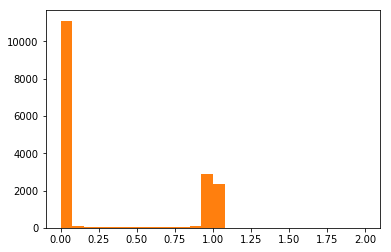

In [18]:
import matplotlib.pyplot as plt
plt.hist(user_data, bins='auto')
plt.show()

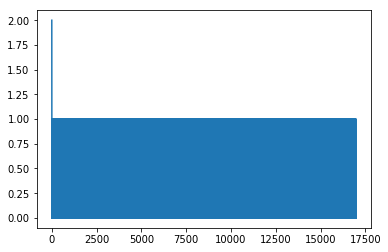